# **Imports**

In [84]:
import pandas as pd
#import ydata_profiling as pp
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# **Problem**
Predict the average price of apples for the following week

In [85]:
file = 'apples.csv'
df = pd.read_csv(file)
df.dtypes

Unnamed: 0         int64
date              object
average_price    float64
total_volume       int64
gala               int64
fuji               int64
granny_smith       int64
total_bags         int64
s_bags             int64
l_bags             int64
xl_bags            int64
type              object
region            object
dtype: object

# **1. Pre-process**

Working only with region TotalUS due to granularity 

In [86]:
##Pre-pre-process

#Removing what is not TotalUS
df = df[df['region'] == 'TotalUS'].copy()

#Casting date as datetime type
df['date'] = pd.to_datetime(df['date'], format='%m/%d/%Y')
df = df.sort_values('date')

#Separating by conventional and organic
df_conv = df[df['type'] == 'conventional']
df_org = df[df['type'] == 'organic']

#Choosing columns of interest
columns_of_interest = ['date', 'average_price', 'total_volume', 'gala', 'fuji', 'granny_smith', 'total_bags', 's_bags', 'l_bags', 'xl_bags']
df_conv = df_conv[columns_of_interest]
df_org = df_org[columns_of_interest]
columns_of_interest.append('type')
df = df[columns_of_interest]

In [87]:
#Calender features
def calender_features(data):
    data['week'] = data['date'].dt.isocalendar().week
    data['week'] = data['week'].astype('int32')
    data['month'] = data['date'].dt.month
    data['year'] = data['date'].dt.year

calender_features(df)
calender_features(df_conv)
calender_features(df_org)


# **2.Exploratory data-analysis**

In [88]:
#Seaborn styles
sns.set_theme()
sns.set(style="whitegrid")
sns.set_palette("Set2")
plt.style.use('seaborn-v0_8')

Data distribution by year

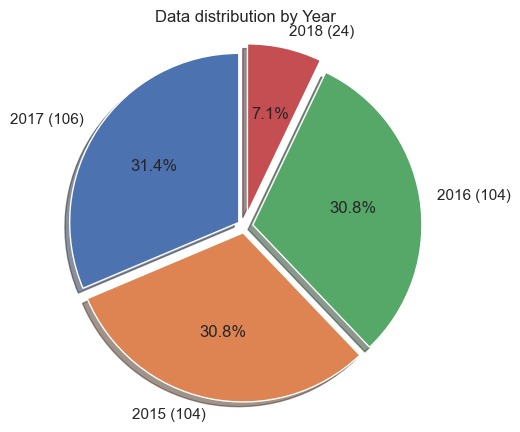

In [89]:
year_count = df["year"].value_counts()
sns.set(font_scale=1)

plt.figure(figsize=(5, 5))
plt.title("Data distribution by Year")

explode = (0.04, 0.04, 0.05, 0.08)  

labels = [f"{year} ({count})" for year, count in zip(year_count.index, year_count.values)]

plt.pie(year_count, labels=labels, autopct='%1.1f%%', explode=explode, shadow=True, startangle=90)
plt.axis('equal')  # Equal aspect ratio ensures that the pie is drawn as a circle

plt.show()

2018 has less data, we don't have the hole year
2016 and 2015 have 52 weeks each (double the data because we're dealing with two types)
2017 has 53 weeks?

Total volume by type

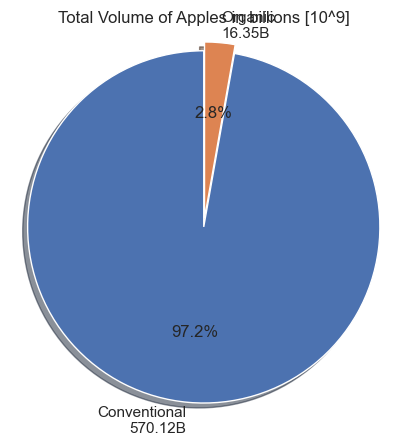

In [90]:
conv_totalV = df_conv['total_volume'].sum() / 1e9
orga_totalV = df_org['total_volume'].sum() / 1e9
values = [round(conv_totalV, 2), round(orga_totalV, 2)]
labels = ['Conventional', 'Organic']

sns.set(font_scale=1)
plt.figure(figsize=(5, 5))
plt.title('Total Volume of Apples in billions [10^9]')

# Explode a slice for emphasis (optional)
explode = (0, 0.05)

# Label formatting
labels_with_values = [f'{label}\n{value:.2f}B' for label, value in zip(labels, values)]

plt.pie(values, labels=labels_with_values, autopct='%1.1f%%', explode=explode, shadow=True, startangle=90)
plt.axis('equal')  # Equal aspect ratio ensures that the pie is drawn as a circle

plt.show()


Conventional apples by cultivar

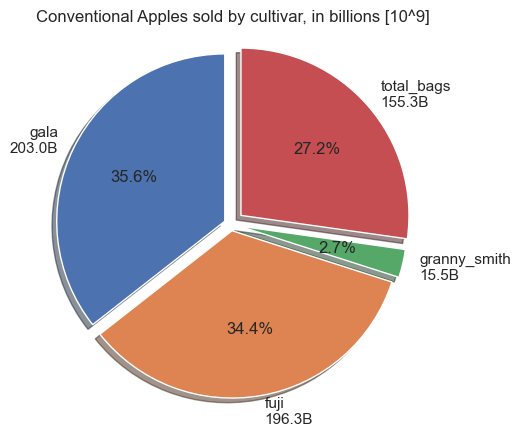

In [91]:
def pie_chart_per_apple_type(d, title):
    apple_type = ['gala', 'fuji', 'granny_smith', 'total_bags']
    values = [round(d[apple].sum() / 1e9, 1) for apple in apple_type]
    labels = [f'{label}\n{value:.1f}B' for label, value in zip(apple_type, values)]

    sns.set(font_scale=1)
    plt.figure(figsize=(5, 5))
    plt.title(title)

    explode = (0.04, 0.04, 0.05, 0.08)  

    plt.pie(values, labels=labels, autopct='%1.1f%%', explode=explode, shadow=True, startangle=90)
    plt.axis('equal')  # Equal aspect ratio ensures that the pie is drawn as a circle

    plt.show()

pie_chart_per_apple_type(df_conv, 'Conventional Apples sold by cultivar, in billions [10^9]')


Price and volume analysis

1.65
0.76
2.09
1.0


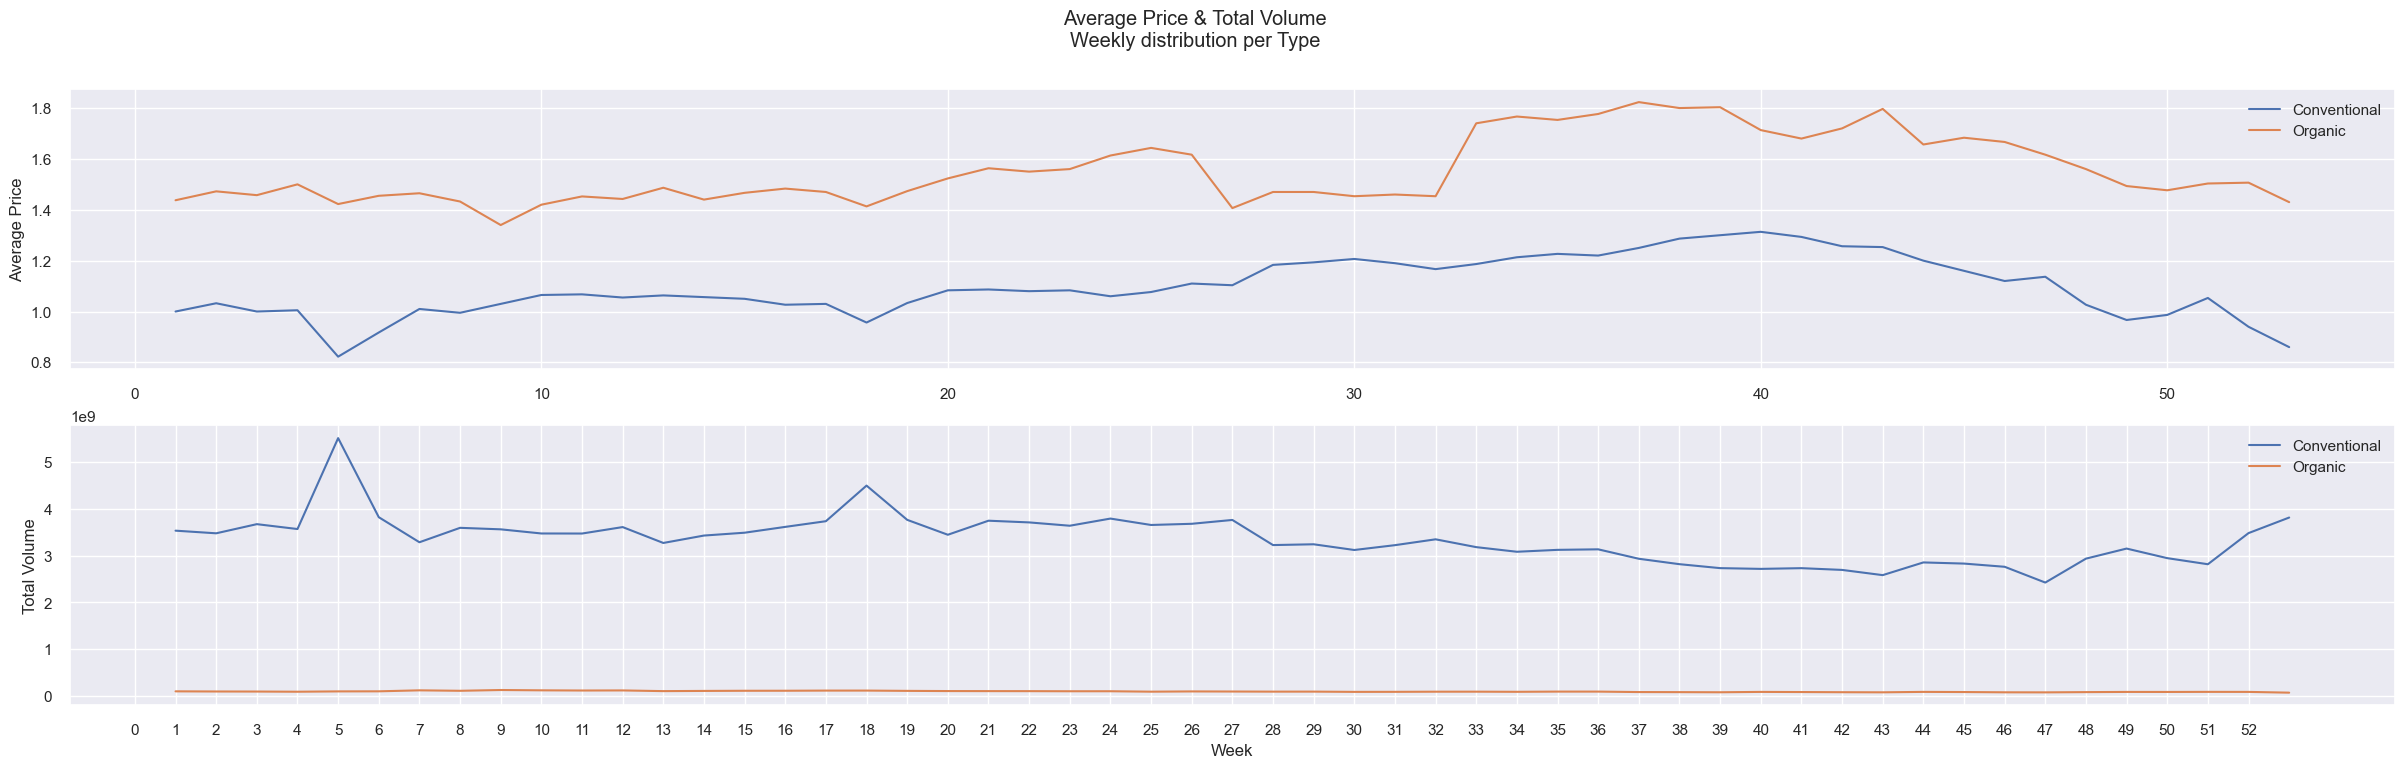

In [92]:
figure, ax = plt.subplots(2,1,figsize=(30,8))
listOf_Xticks = np.arange(0, 53, 1)
plt.xticks(listOf_Xticks)
figure.suptitle("Average Price & Total Volume\nWeekly distribution per Type")
plt.xlabel("Week")
ax[0].set_ylabel("Average Price")
ax[1].set_ylabel("Total Volume")

#Feature engineeering
df_org['week'] = df_org['date'].dt.isocalendar().week

#df_avg_price_conv = df[df['type']=='conventional']
#df_avg_price_org = df[df['type']=='organic']
df_avg_price_conv_week = df_conv['average_price'].groupby(df_conv['week']).mean()
df_avg_price_org_week =  df_org['average_price'].groupby(df_org['week']).mean()
df_volume_conv_week = df_conv['total_volume'].groupby(df_conv['week']).mean()
df_volume_org_week =  df_org['total_volume'].groupby(df_org['week']).mean()


ax[0].plot(df_avg_price_conv_week, label="Conventional")
ax[0].plot(df_avg_price_org_week, label="Organic")
ax[1].plot(df_volume_conv_week, label="Conventional")
ax[1].plot(df_volume_org_week, label="Organic")
ax[0].legend()
ax[1].legend()

print(df_conv['average_price'].max())
print(df_conv['average_price'].min())
print(df_org['average_price'].max())
print(df_org['average_price'].min())

Monthly average prices

In [93]:
def groupby_month(d): #Group by month and average the price
    d_new = d.groupby('month')['average_price'].mean().reset_index()
    months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    d_new['month'] = d_new['month'].apply(lambda x: months[x - 1])
    return d_new #Returns list of average prices for each month

def grafico_fixe(d): #escolham um melhor nome pls
    years = d['year'].unique()
    for year in years:
        provisoria = groupby_month(d[d['year']==year])
        sns.scatterplot(x=provisoria['month'], y=provisoria['average_price'], label=year)
        plt.plot(provisoria['month'], provisoria['average_price'])

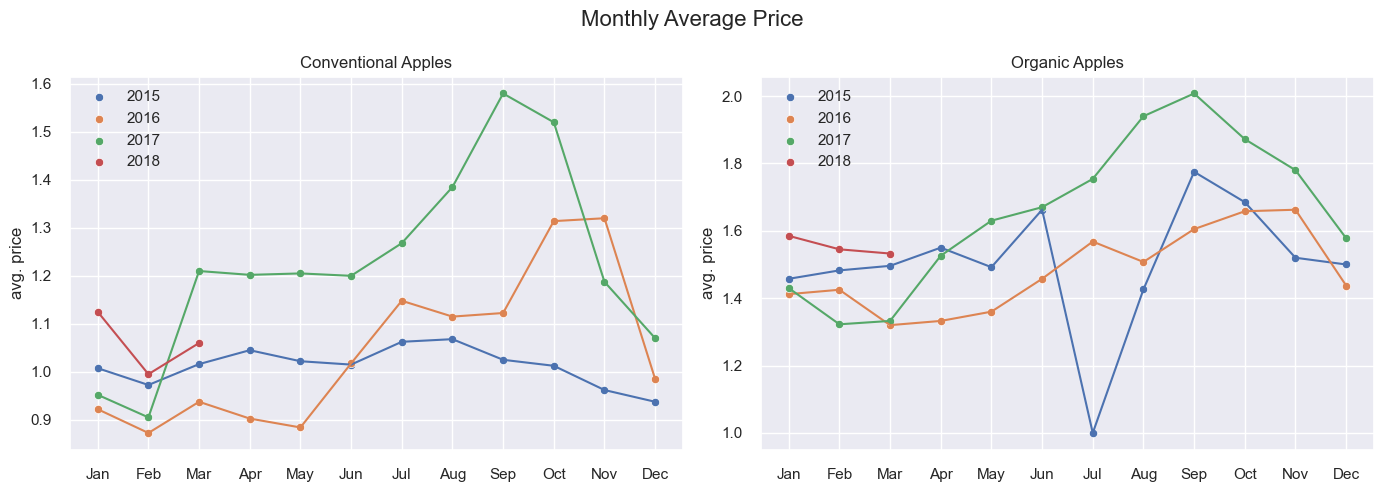

In [94]:
plt.figure(figsize=(14, 5))
plt.suptitle('Monthly Average Price', fontsize=16)

plt.subplot(1, 2, 1) #1st plot
grafico_fixe(df_conv)
plt.xlabel('')
plt.ylabel('avg. price')
plt.title('Conventional Apples')
plt.legend(loc='upper left')

plt.subplot(1, 2, 2) #2nd plot
grafico_fixe(df_org)
plt.xlabel('')
plt.ylabel('avg. price')
plt.title('Organic Apples')
plt.legend()
plt.tight_layout()

That dip on organic prices (jul-2015) needs to be solved! 

# **3. Models**

In [95]:
df_conv['target'] = df_conv['average_price'].shift(-1)
df_conv = df_conv.loc[df_conv['target'].notna()].copy().reset_index(drop = True)

split_date = pd.to_datetime('2018-01-01')

#Spliting into training and test data
df_conv_train = df_conv.loc[df_conv['date'] < split_date].copy().reset_index(drop=True)
df_conv_test = df_conv.loc[df_conv['date'] >= split_date].copy().reset_index(drop=True)

def print_stats(df_set, df):
    print(f'Percentage of original: {len(df_set) / len(df):.0%}')
    print('Target min: {}'.format(df_set["target"].min()))
    print(f'Target median:\t{df_set["target"].median():,.2f}')
    print(f'Target mean:\t{df_set["target"].mean():,.2f}')
    print(f'Target max:\t{df_set["target"].max():,.2f}')

print('\nFull train')
print_stats(df_conv_train, df_conv)
print('\nTest')
print_stats(df_conv_test, df_conv)


Full train
Percentage of original: 93%
Target min: 0.76
Target median:	1.04
Target mean:	1.10
Target max:	1.65

Test
Percentage of original: 7%
Target min: 0.87
Target median:	1.07
Target mean:	1.05
Target max:	1.20


3.1 Baseline: xgboost gradient descent regression

In [96]:
from xgboost import XGBRegressor

#Hyper-parameters
algo_params = {
    'max_depth': 6, #tree-depth
    'n_estimators': 80, #number of trees
}
algo_params['seed'] = 123 
algo_params['n_jobs'] = -1 #PC config to use all local clusters
algo_params['tree_method'] = 'hist' #histogram-based method for faster training
algo_params['use_label_encoder'] = False #No label encoding for categorical features

#Create instance of regression model with the params
model = XGBRegressor(**algo_params)  #**: dic key-value pairs as keyword args to the constructor 
                                     #-> same thing as explicitly writing each h-param in the function

#### features used
numeric_features_used = [
    'average_price',
    'total_volume',
    'gala',
    'fuji',
    'granny_smith',
    'total_bags',
    's_bags',
    'l_bags',
    'xl_bags',
]

model.fit( #Training the model
    df_conv_train[numeric_features_used],
    df_conv_train['target']
    )

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=80, n_jobs=-1,
             num_parallel_tree=None, random_state=None, ...)

Evaluating the model

In [97]:
from sklearn.metrics import mean_squared_error

def print_score(model, train, test, features):
    preds_train = model.predict(train[features])
    rmse_train = mean_squared_error(train['target'], preds_train, squared = False)

    preds_test = model.predict(test[features])
    rmse_test = mean_squared_error(test['target'], preds_test, squared = False)

    overfit = rmse_test - rmse_train

    print('Train score: {}\n'.format(rmse_train))
    print(f'Test score: {rmse_test:,.5f} \t||\t Overfit: {overfit:,.5f}')
    
print_score(model, df_conv_train, df_conv_test, numeric_features_used)

Train score: 0.0009072762634834784

Test score: 0.11312 	||	 Overfit: 0.11221


In [98]:
if hasattr(model, 'feature_importances_'):
    feature_importances = model.feature_importances_
    
#Create a DataFrame for feature importances
feature_importance_df = pd.DataFrame({'Feature': numeric_features_used, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Display the table
feature_importance_df

,Feature,Importance
0,average_price,0.794081
5,total_bags,0.043269
8,xl_bags,0.033429
2,gala,0.026290
3,fuji,0.026186
6,s_bags,0.024848
7,l_bags,0.022317
1,total_volume,0.019450
4,granny_smith,0.010132


3.2 Feature Engineering

In [99]:
#Moving average for average_price
month_size = 4
df_conv['RM_avgP_M'] = df_conv['average_price'].rolling(window=month_size, min_periods=0).mean()

#Price elasticity: measure of how price increase affects volume
df_conv['price_elasticity'] = (df_conv['total_volume'].pct_change())/(df_conv['average_price'].pct_change())
df_conv.at[0, 'price_elasticity'] = 0 #Coloca '0' como o primeiro valor da price elasticity, qual seria uma boa opção?

numeric_features_used = [
    'average_price',
    'total_volume',
    'gala',
    'fuji',
    'granny_smith',
    'total_bags',
    's_bags',
    'l_bags',
    'xl_bags',
    'RM_avgP_M',
    'week',
    'month',
    'year',
    #'price_elasticity'
]

#Spliting into training and test data
df_conv_train = df_conv.loc[df_conv['date'] < split_date].copy().reset_index(drop=True)
df_conv_test = df_conv.loc[df_conv['date'] >= split_date].copy().reset_index(drop=True)


xgboost gradient descent regression with grid search

In [100]:
#Finding the best h-params for Xgboost model by grid search and cross-validation (TimeSeriesSplit)
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.compose import TransformedTargetRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import MinMaxScaler

# basic config to be used in all combinations
algo_params['seed'] = 123
algo_params['n_jobs'] = -1
algo_params['tree_method'] = 'hist'
algo_params['use_label_encoder'] = False

#core model
model = XGBRegressor(**algo_params)

#target transformer
target_scale = MinMaxScaler(feature_range = (1, 10000))
target_norm = QuantileTransformer(
    n_quantiles = 100,
    output_distribution = 'normal',
    random_state = 123
)
target_norm = Pipeline([('min', target_scale), ('quantile', target_norm)])

#model inside a pipeline
model = TransformedTargetRegressor(regressor = model, transformer = target_norm)

# params to search for
parameters = {
    'regressor__n_estimators': [60, 80], 
    'regressor__max_depth': [5, 7],
}

# if you were using a model without transformers and pipeline, would be something like this
# parameters = {
#     'n_estimators': [60, 80], 
#     'max_depth': [5, 7],
# }

cv_splitter = TimeSeriesSplit(
    n_splits = 3,
    gap = 0,
)

#Trains the model on different combinations of h-params
#Evaluates performance with cv amd chooses the best combination
grid = GridSearchCV(
    estimator = model,
    param_grid = parameters,
    cv = cv_splitter,
    n_jobs = -1,
    refit = True,
)

grid.fit(
    df_conv_train[numeric_features_used],
    df_conv_train['target'],
)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
             estimator=TransformedTargetRegressor(regressor=XGBRegressor(base_score=None,
                                                                         booster=None,
                                                                         callbacks=None,
                                                                         colsample_bylevel=None,
                                                                         colsample_bynode=None,
                                                                         colsample_bytree=None,
                                                                         device=None,
                                                                         early_stopping_rounds=None,
                                                                         enable_categorical=False,
                                                                         eval_metric=None,
                                                                         feature_types...
                                                                         multi_strategy=None,
                                                                         n_estimators=80,
                                                                         n_jobs=-1,
                                                                         num_parallel_tree=None,
                                                                         random_state=None, ...),
                                                  transformer=Pipeline(steps=[('min',
                                                                               MinMaxScaler(feature_range=(1,
                                                                                                           10000))),
                                                                              ('quantile',
                                                                               QuantileTransformer(n_quantiles=100,
                                                                                                   output_distribution='normal',
                                                                                                   random_state=123))])),
             n_jobs=-1,
             param_grid={'regressor__max_depth': [5, 7],
                         'regressor__n_estimators': [60, 80]})

In [101]:
pd.DataFrame(grid.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_regressor__max_depth,param_regressor__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.196026,0.058736,0.011832,0.001867,5,60,"{'regressor__max_depth': 5, 'regressor__n_esti...",-0.268065,-1.150348,0.099797,-0.439539,0.524575,3
1,0.228784,0.096621,0.012644,0.003068,5,80,"{'regressor__max_depth': 5, 'regressor__n_esti...",-0.268063,-1.150733,0.097914,-0.440294,0.524104,4
2,0.288151,0.063572,0.013471,0.004504,7,60,"{'regressor__max_depth': 7, 'regressor__n_esti...",-0.003380,-1.030976,0.166744,-0.289204,0.529090,2
3,0.278232,0.075671,0.013636,0.003734,7,80,"{'regressor__max_depth': 7, 'regressor__n_esti...",-0.003379,-1.030976,0.166746,-0.289203,0.529091,1


In [102]:
best_model = grid.best_estimator_

print_score(best_model, df_conv_train, df_conv_test, numeric_features_used)

Train score: 0.0001672564597751482

Test score: 0.11406 	||	 Overfit: 0.11390


In [103]:
feature_importances = best_model.regressor_.feature_importances_

feature_importance_df = pd.DataFrame({'Feature': numeric_features_used, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Display the table
feature_importance_df


,Feature,Importance
0,average_price,0.419080
9,RM_avgP_M,0.334495
10,week,0.071100
2,gala,0.030497
8,xl_bags,0.027357
4,granny_smith,0.026886
1,total_volume,0.024441
7,l_bags,0.015827
5,total_bags,0.015711
3,fuji,0.015053


More feature engineering

In [104]:
#Previous week
df_conv['week_prev'] = df_conv['week'].shift(1) #All correct except the first
df_conv.at[0, 'week_prev'] = 52
df_conv['week_prev'] = df_conv['week_prev'].astype('int32')

#Previous month
df_conv['month_prev'] = df_conv['date'].dt.month -1
df_conv.loc[df_conv['month_prev'] == 0, 'month_prev'] = 12

#Reordering columns
df_conv = df_conv[["date", "average_price", "total_volume", "gala", "fuji", "granny_smith", "total_bags", "s_bags", "l_bags", "xl_bags", "year", "target", "RM_avgP_M", "price_elasticity", "week", "week_prev", "month", "month_prev"]]

#Two extra moving averages due to the importance of the monthly moving average
alpha = 2/(month_size+1)
df_conv['EMA_avgP_M'] = df_conv['average_price'].ewm(span=month_size, adjust=False).mean() #exponentional moving average
quatrer_size = 13
df_conv['RM_avgP_Q'] = df_conv['average_price'].rolling(window=quatrer_size, min_periods=0).mean()

Repeating the model

In [105]:
numeric_features_used = [
    'average_price',
    'total_volume',
    #'gala',
    #'fuji',
    #'granny_smith',
    #'total_bags',
    #'s_bags',
    #'l_bags',
    #'xl_bags',
    'RM_avgP_M',
    'week',
    'week_prev',
    'month',
    'month_prev',
    'year',
    #'price_elasticity'
    'EMA_avgP_M',
    'RM_avgP_Q'
]

#Spliting into training and test data
df_conv_train = df_conv.loc[df_conv['date'] < split_date].copy().reset_index(drop=True)
df_conv_test = df_conv.loc[df_conv['date'] >= split_date].copy().reset_index(drop=True)


grid.fit(
    df_conv_train[numeric_features_used],
    df_conv_train['target'],
)

best_model = grid.best_estimator_


print_score(best_model, df_conv_train, df_conv_test, numeric_features_used)

Train score: 0.000215256847068596

Test score: 0.10308 	||	 Overfit: 0.10287


In [106]:
feature_importances = best_model.regressor_.feature_importances_

feature_importance_df = pd.DataFrame({'Feature': numeric_features_used, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Display the table
feature_importance_df

,Feature,Importance
0,average_price,0.349878
7,year,0.198707
4,week_prev,0.164982
2,RM_avgP_M,0.124494
3,week,0.059344
6,month_prev,0.050499
9,RM_avgP_Q,0.031049
1,total_volume,0.015327
8,EMA_avgP_M,0.005695
5,month,0.000025


Preparing data to use on RF

In [110]:
df_conv_train.head()

,date,average_price,total_volume,gala,fuji,granny_smith,total_bags,s_bags,l_bags,xl_bags,year,target,RM_avgP_M,price_elasticity,week,week_prev,month,month_prev,EMA_avgP_M,RM_avgP_Q
0,2015-01-04,0.95,3132427773,1235716134,1362408305,84409332,449894002,358532158,89494563,1867281,2015,1.01,0.950000,0.000000,1,52,1,12,0.950000,0.950000
1,2015-01-11,1.01,2906354275,1154481053,1213477338,86657466,451738418,378326116,71833387,1578915,2015,1.03,0.980000,-1.142723,2,1,1,12,0.974000,0.980000
2,2015-01-18,1.03,2904345885,1185813934,1170194780,83130190,465206981,387304126,77109320,793535,2015,1.04,0.996667,-0.034897,3,2,1,12,0.996400,0.996667
3,2015-01-25,1.04,2847031084,1216744503,1073465282,76802005,480019294,397863690,81292473,863131,2015,0.89,1.007500,-2.032618,4,3,1,12,1.013840,1.007500
4,2015-02-01,0.89,4465546151,1893303804,1895647974,138151611,538442762,421645203,112107647,4689912,2015,0.95,0.992500,-3.941546,5,4,2,1,0.964304,0.984000


In [112]:
#Separating target
df_convY = df_conv_train['target']
df_convY.head()



#Data to use 
df_convX = df_conv_train[numeric_features_used]


In [117]:
df_convX

,average_price,total_volume,RM_avgP_M,week,week_prev,month,month_prev,year,EMA_avgP_M,RM_avgP_Q
0,0.95,3132427773,0.950000,1,52,1,12,2015,0.950000,0.950000
1,1.01,2906354275,0.980000,2,1,1,12,2015,0.974000,0.980000
2,1.03,2904345885,0.996667,3,2,1,12,2015,0.996400,0.996667
3,1.04,2847031084,1.007500,4,3,1,12,2015,1.013840,1.007500
4,0.89,4465546151,0.992500,5,4,2,1,2015,0.964304,0.984000
...,...,...,...,...,...,...,...,...,...,...
152,1.09,3382424000,1.162500,48,47,12,11,2017,1.174988,1.399231
153,1.03,3563491301,1.132500,49,48,12,11,2017,1.116993,1.358462
154,1.07,3075776703,1.107500,50,49,12,11,2017,1.098196,1.320000
155,1.18,2910234933,1.092500,51,50,12,11,2017,1.130917,1.286154


In [114]:
from sklearn import ensemble
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split


In [118]:
train_X, test_X, train_Y, test_Y = train_test_split(df_convX, df_convY, test_size=0.2, shuffle=False)
train_X = train_X.values
train_Y = train_Y.values

tuned_parameters = {
 'n_estimators': [500, 700, 1000],
 'max_depth': [ 1, 2, 3],
 'min_samples_split': [0.2, 0.5, 0.8]
}



In [126]:
GSDTR = GridSearchCV(
   ensemble.RandomForestRegressor(),
   tuned_parameters,
   cv=5,
   scoring=["r2","neg_mean_squared_error"],
   n_jobs=-1,
   verbose=4,
   refit = False
)



In [130]:
DTR_result = GSDTR.fit(train_X,train_Y)
best_score = DTR_result.best_score_
#print(DTR_result.best_estimator_.get_params())

Fitting 5 folds for each of 27 candidates, totalling 135 fits


AttributeError: 'GridSearchCV' object has no attribute 'best_score_'

In [ ]:
print_score